#If Berlin Was Boston

In [109]:
# import libraries
import pandas as pd
from pandas.plotting import register_matplotlib_converters, parallel_coordinates, boxplot_frame, boxplot_frame_groupby
register_matplotlib_converters()
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
from helpers import price_parse, percent_parse, valid_value_intbool, multicategorical_to_dummies, make_dummies
import locale; locale.setlocale(locale.LC_ALL, 'en_US.UTF-8');

In [110]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

## Reading and Joining Data

In [111]:
# read data and join
#Boston
bos_lis = pd.read_csv('data/boston/listings.csv', sep=',', header=0,
                    parse_dates=['last_scraped', 'host_since', 'calendar_updated',
                                 'calendar_last_scraped', 'first_review', 'last_review'],
                    infer_datetime_format=True,
                    converters={'price': price_parse, 'weekly_price': price_parse,
                                'monthly_price': price_parse, 'security_deposit': price_parse,
                                'cleaning_fee': price_parse, 'extra_people': price_parse,
                                'host_acceptance_rate': percent_parse, 'host_response_rate': percent_parse},
                    true_values=['t'], false_values=['f'],
                    index_col='id')
#Berlin
ber_lis = pd.read_csv('data/berlin/listings_summary.csv', sep=',', header=0,
                    parse_dates=['last_scraped', 'host_since', 'calendar_updated',
                                 'calendar_last_scraped', 'first_review', 'last_review'],
                    infer_datetime_format=True,
                    converters={'price': price_parse, 'weekly_price': price_parse,
                                'monthly_price': price_parse, 'security_deposit': price_parse,
                                'cleaning_fee': price_parse, 'extra_people': price_parse,
                                'host_acceptance_rate': percent_parse, 'host_response_rate': percent_parse},
                    true_values=['t'], false_values=['f'],
                    index_col='id')

C:\Users\ruindur\.conda\envs\airbnb_blog\lib\site-packages\IPython\core\interactiveshell.py:2714: DtypeWarning: Columns (28,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Pre-Processing and Cleanup

In [112]:
# Pre-Process
# join in here to avoid problems with dropped columns upon re-running
listings = pd.concat([bos_lis.assign(**{'source': lambda x: 'Boston'}),
                      ber_lis.assign(**{'source': lambda x: 'Berlin'})], axis=0,
                     ignore_index=True, sort=False).dropna(how='all', axis=1)
# column categories
listings_categorical = ['experiences_offered', 'host_location', 'host_response_time',
                        'host_neighbourhood',
                        'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city',
                        'state', 'zipcode', 'market', 'source', 'smart_location',
                        'property_type', 'cancellation_policy',
                        'room_type', 'bed_type', 'calendar_updated']
listings_presence = []
listings_text = ['name', 'summary', 'space', 'description', 'notes', 'neighborhood_overview',
                 'transit', 'host_about', 'host_name', 'street', 'neighborhood']
listings_multi_categories = ['amenities'] #,'host_verifications']
listings_numeric = listings.select_dtypes('number').columns

# actual URLs are not interesting, but presence could be of value
for col in listings.columns:
    if 'url' in col:
        pcol = 'has_' + col
        listings[pcol] = listings[col].apply(valid_value_intbool, convert_dtype=True)
        listings.drop(col, axis=1, inplace=True)
        listings_presence.append(pcol)

# expand the selected multi-catergorical columns to dummy variables
for col in listings_multi_categories:
    multicat = multicategorical_to_dummies(listings[col])
    listings = listings.join(multicat)
    listings.drop(col, axis=1)

# remove columns where all values are the same
listings_all_same = []
for col in listings_categorical:
    if listings[col].value_counts(dropna=False).shape[0] == 1:
        listings_all_same.append(col)
        listings_categorical.remove(col)

for col in listings_presence:
    if listings[col].value_counts(dropna=False).shape[0] == 1:
        listings_all_same.append(col)
        listings_presence.remove(col)

for col in listings_numeric:
    if listings[col].value_counts(dropna=False).shape[0] == 1:
        listings_all_same.append(col)
        listings_numeric.remove(col)

listings = listings.drop(listings_all_same, axis=1)
listings.sample(10)

,scrape_id,last_scraped,name,summary,space,description,neighborhood_overview,notes,transit,access,...,amenities_Wide clearance to shower,amenities_Wide doorway,amenities_Wide entryway,amenities_Wide hallway clearance,amenities_Wifi,amenities_Window guards,amenities_Wireless Internet,amenities_toilet,amenities_translation missing: en.hosting_amenity_49,amenities_translation missing: en.hosting_amenity_50
20942,20181107122246,2018-11-07,Friedrichshain - between Warschauer Str./Ostkreuz,Nice and cozy apartment in the central area of...,NaN,Nice and cozy apartment in the central area of...,NaN,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
21597,20181107122246,2018-11-07,Modern & spacious duplex apartment with a balcony,"Welcome to Berlin! Since I’m traveling myself,...",My beautifully and yet minimalistically set up...,"Welcome to Berlin! Since I’m traveling myself,...",My duplex apartment is located in the district...,NaN,The apartment offers you a very good connectio...,"During your stay, you'll have the whole apartm...",...,0,0,0,0,1,0,0,0,0,0
3883,20181107122246,2018-11-07,"Wendt-Apartment, 2nd floor, quiet",Im sanierten Seitenflügel eines Altbau-Wohnhau...,Stylish accommodation with high quality furnit...,Stylish accommodation with high quality furnit...,In direkter Umgebung ist ein Supermarkt mit Bä...,Im 2. Stock ohne Fahrstuhl,Der Bahnhof Ostkreuz ist nur 7 Gehminuten entf...,Ihr habt eine ganze Wohnung für Euch.,...,1,1,1,1,1,1,0,1,0,0
16047,20181107122246,2018-11-07,Zentru (Hidden by Airbnb) ahe 2-Raum Wohnung i...,Nice new renovated 2 room Appartment (45 qm) i...,NaN,Nice new renovated 2 room Appartment (45 qm) i...,NaN,NaN,NaN,the whole Appartment,...,0,0,0,0,1,0,0,0,1,1
19291,20181107122246,2018-11-07,Wg Zimmer in 3er Wg in Neukölln,"Zimmer mit Doppelbett plus ausziehbarer Couch,...",NaN,"Zimmer mit Doppelbett plus ausziehbarer Couch,...",NaN,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
10268,20181107122246,2018-11-07,cosy appartement,Die kuschelige 1-Zimmer-Wohnung liegt sehr zen...,NaN,Die kuschelige 1-Zimmer-Wohnung liegt sehr zen...,NaN,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
22788,20181107122246,2018-11-07,"Luxury studio Charlottenburg - ZOB, Messe, Oly...",Deluxe studio in Charlottenburg- Messe-Olympia...,In meinem Apartment finden Sie viele Annehmlic...,Deluxe studio in Charlottenburg- Messe-Olympia...,Die Apartments befinden sich nur wenige Gehmin...,NaN,Die U-Bahn- Westend ist nur 5 Gehminuten entfe...,Sie haben das Apartment komplett zu Ihrer eige...,...,0,1,1,0,1,1,0,0,0,0
6895,20181107122246,2018-11-07,sunny and spacious loft. top floor!,"this comfortable, sunny and spacious loft offe...","Its very spacious, bright and calm. The only ""...","this comfortable, sunny and spacious loft offe...",there is a subway stop 100 meters from this pl...,there is a baby-seat and travel bed for very s...,"subway U6, busses and night busses only 100 me...",NaN,...,0,0,0,0,1,0,0,0,0,0
3461,20160906204935,2016-09-07,Close to Harvard - Zen Room,Top floor bedroom with a shared bathroom (shar...,Guest will have access to a private bedroom an...,Top floor bedroom with a shared bathroom (shar...,"Very safe residential neighborhood, with great...",NaN,Bus stop is two blocks from the house with acc...,Guest will have access to a private bedroom an...,...,0,0,0,0,0,0,1,0,0,0
22954,20181107122246,2018-11-07,Central private room (flatshare/WG),"Nice room in central area. With, wifi, laundry...",NaN,"Nice room in central area. With, wifi, laundry...",NaN,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0


## Average Listing Properties by Neighbourhood

In [113]:
# no id columns here, no scrape metadata
aggregateable_cols = list(listings.columns)

# removing some columns that seem not useful
for col in listings.columns:
    if '_id' in col or 'scrape' in col:
        aggregateable_cols.remove(col)

exclude_columns = ['latitude', 'longitude', # will only create distance between Boston and Berlin neighbourhoods
                   'amenities_', # looks like an artifact from multi-categorical expansion
                   'amenities_translation missing: en.hosting_amenity_49', # impossible to interpret
                   'amenities_translation missing: en.hosting_amenity_50', # impossible to interpret
                   'host_neighbourhood', # more interesting to check if host lives in same neighborhood as listing
                   'host_location', 'smart_location', # too spammy
                   'neighbourhood_cleansed', # too much coorelationm to neighborhood
                   'neighbourhood_group_cleansed', # same, maybe use as replacement for neighbourhood
                   'market', 'source', # will only create distance between Boston and Berlin neighbourhoods
                   'calendar_updated', # metadata
                   'city', 'state', 'zipcode', # will only create distance between Boston and Berlin neighbourhoods
                   ]

for col in exclude_columns:
    if col in aggregateable_cols:
        aggregateable_cols.remove(col)


dummy_cols = []
num_cols = []
for col in aggregateable_cols:
    if col in listings_categorical:
        dummy_cols.append(col)
    else:
        num_cols.append(col)

print(*aggregateable_cols, sep=',\n')

name,
summary,
space,
description,
neighborhood_overview,
notes,
transit,
access,
interaction,
house_rules,
host_name,
host_since,
host_about,
host_response_time,
host_response_rate,
host_acceptance_rate,
host_is_superhost,
host_listings_count,
host_total_listings_count,
host_verifications,
host_has_profile_pic,
street,
neighbourhood,
country_code,
country,
is_location_exact,
property_type,
room_type,
accommodates,
bathrooms,
bedrooms,
beds,
bed_type,
amenities,
square_feet,
price,
weekly_price,
monthly_price,
security_deposit,
cleaning_fee,
guests_included,
extra_people,
minimum_nights,
maximum_nights,
has_availability,
availability_30,
availability_60,
availability_90,
availability_365,
number_of_reviews,
first_review,
last_review,
review_scores_rating,
review_scores_accuracy,
review_scores_cleanliness,
review_scores_checkin,
review_scores_communication,
review_scores_location,
review_scores_value,
requires_license,
license,
instant_bookable,
cancellation_policy,
require_guest_profil

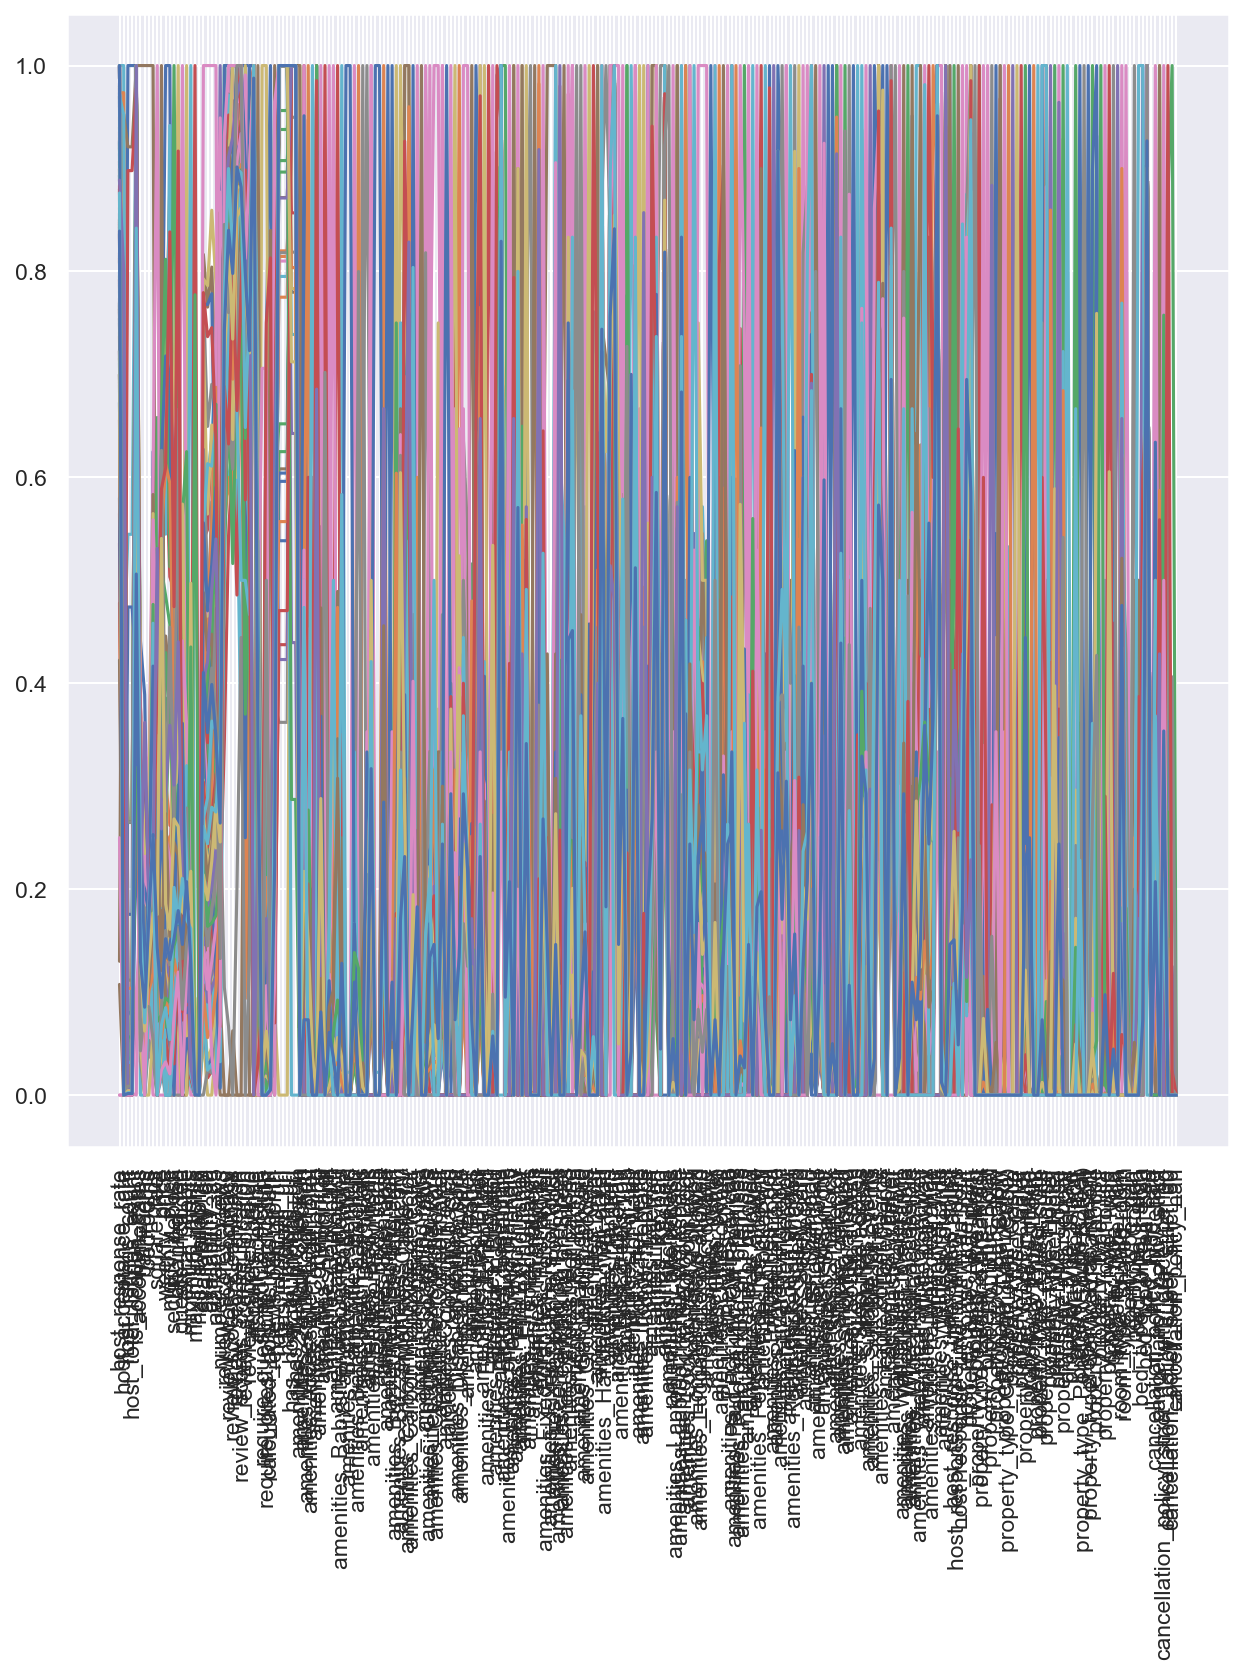

In [114]:
nbh_mean = listings[num_cols].join(make_dummies(listings[dummy_cols]), how='left') .groupby(['neighbourhood',]).mean()
nbh_mean_norm = nbh_mean.apply(lambda col: (col - col.min()) / (col.max() - col.min()))
plt.figure(figsize=(10,10), dpi=150)
for nbh in nbh_mean_norm.index:
    plt.plot(nbh_mean_norm.columns, nbh_mean_norm.fillna(0).loc[nbh], label=nbh)
plt.xticks(rotation=90);

In [115]:
# get numbers of neighbourhoods per city
nbh_counts = listings.groupby('source')['neighbourhood'].value_counts()
ber_nbh_count = nbh_counts['Berlin'].index.shape[0]
ber_nbh_nam = list(nbh_counts['Berlin'].index)
bos_nbh_count = nbh_counts['Boston'].index.shape[0]
bos_nbh_nam = list(nbh_counts['Boston'].index)
print('Neighbourhoods in Boston: {}  | in Berlin {}'.format(bos_nbh_count, ber_nbh_count))


Neighbourhoods in Boston: 30  | in Berlin 91


## Comparing Neighourhoods by Properties


In [116]:
print(nbh_mean.describe())


       host_response_rate  host_acceptance_rate  host_listings_count  \
count          120.000000             30.000000           121.000000   
mean             0.939326              0.859307            20.354148   
std              0.059221              0.096479            64.624912   
min              0.666667              0.578333             1.000000   
25%              0.918154              0.828377             1.409091   
50%              0.948202              0.870861             1.821429   
75%              0.978929              0.925880             3.685714   
max              1.000000              1.000000           394.038462   

       host_total_listings_count  is_location_exact  accommodates   bathrooms  \
count                 121.000000         121.000000    121.000000  121.000000   
mean                   20.354148           0.819880      3.056700    1.172004   
std                    64.624912           0.145213      0.879899    0.172654   
min                     1.0

In [117]:
print(*list(nbh_mean.columns), sep='\n')


host_response_rate
host_acceptance_rate
host_listings_count
host_total_listings_count
is_location_exact
accommodates
bathrooms
bedrooms
beds
square_feet
price
weekly_price
monthly_price
security_deposit
cleaning_fee
guests_included
extra_people
minimum_nights
maximum_nights
has_availability
availability_30
availability_60
availability_90
availability_365
number_of_reviews
review_scores_rating
review_scores_accuracy
review_scores_cleanliness
review_scores_checkin
review_scores_communication
review_scores_location
review_scores_value
requires_license
instant_bookable
require_guest_profile_picture
require_guest_phone_verification
calculated_host_listings_count
reviews_per_month
has_thumbnail_url
has_medium_url
has_xl_picture_url
has_host_thumbnail_url
has_host_picture_url
amenities_24-Hour Check-in
amenities_24-hour check-in
amenities_Accessible-height bed
amenities_Accessible-height toilet
amenities_Air Conditioning
amenities_Air conditioning
amenities_Air purifier
amenities_BBQ grill
am

In [138]:
disfr = pd.DataFrame(index=nbh_mean_norm.loc[ber_nbh_nam].index)
for cindex, cvals in nbh_mean_norm.loc[bos_nbh_nam].iterrows():
    disfr[cindex] = nbh_mean_norm.loc[ber_nbh_nam].apply(lambda x: np.sqrt(np.sum(np.power(x - cvals.values, 2))),
                                                         axis='columns')
disfr['rowmin'] = disfr.min(axis=1)
disfr.loc['colmin'] = disfr.min(axis=0)
disfr.sort_values(by='rowmin', axis=0, inplace=True)
disfr.sort_values(by='colmin', axis=1, inplace=True)
disfr.drop('rowmin', axis=1, inplace=True)
disfr.drop('colmin', axis=0, inplace=True)

In [139]:
disfr.head(125)


,Roxbury,Allston-Brighton,Dorchester,Somerville,Mission Hill,Hyde Park,Beacon Hill,Charlestown,East Boston,Jamaica Plain,...,Theater District,Financial District,Downtown,Cambridge,Leather District,Downtown Crossing,Chinatown,West End,Harvard Square,Government Center
neighbourhood,,,,,,,,,,,,,,,,,,,,,
Grünau,3.503528,3.573873,3.568362,3.641926,3.628439,3.710053,3.739248,3.760516,3.804246,3.780230,...,4.163240,4.270922,4.310174,4.535508,4.622122,4.681304,4.909323,5.023425,5.260916,6.021689
Tempelhof,3.538293,3.539580,3.602395,3.645163,3.625354,3.772592,3.720945,3.775894,3.784485,3.805250,...,4.050689,4.212982,4.293605,4.584638,4.596371,4.589729,4.860989,4.978911,5.187930,5.940289
Baumschulenweg,3.591548,3.587085,3.595715,3.612493,3.655294,3.770981,3.767750,3.809480,3.765719,3.790678,...,4.131937,4.259126,4.348819,4.629273,4.615069,4.629824,4.939034,5.063731,5.282368,6.001504
Neukölln,3.647823,3.609287,3.689358,3.697255,3.700298,3.871232,3.786804,3.873752,3.883917,3.896785,...,4.164898,4.306484,4.388249,4.705156,4.663942,4.695962,4.990484,5.102995,5.306491,6.052510
Alt-Treptow,3.702529,3.649894,3.729743,3.780778,3.732917,3.918985,3.810103,3.871600,3.894885,3.899858,...,4.176430,4.310852,4.421586,4.745567,4.646136,4.658114,4.977387,5.083004,5.264586,6.016731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Karow,5.517109,5.638976,5.560572,5.696316,5.766609,5.595618,5.819869,5.669938,5.655999,5.652556,...,6.034389,6.087412,6.165012,6.310460,6.239479,6.385981,6.431107,6.517708,6.826700,7.206818
Haselhorst,5.690229,5.846997,5.770756,5.790868,6.007663,5.862447,5.907356,5.854687,5.694139,5.872448,...,6.196741,6.278523,6.281421,6.427871,6.314767,6.359241,6.597572,6.787731,6.994807,7.388941
Falkenberg,5.799958,5.817294,5.843918,5.871160,5.862820,5.924955,5.952150,5.893046,5.863614,5.960798,...,6.095540,6.261925,6.290996,6.259732,6.395110,6.367136,6.336805,6.483164,6.780233,7.178764


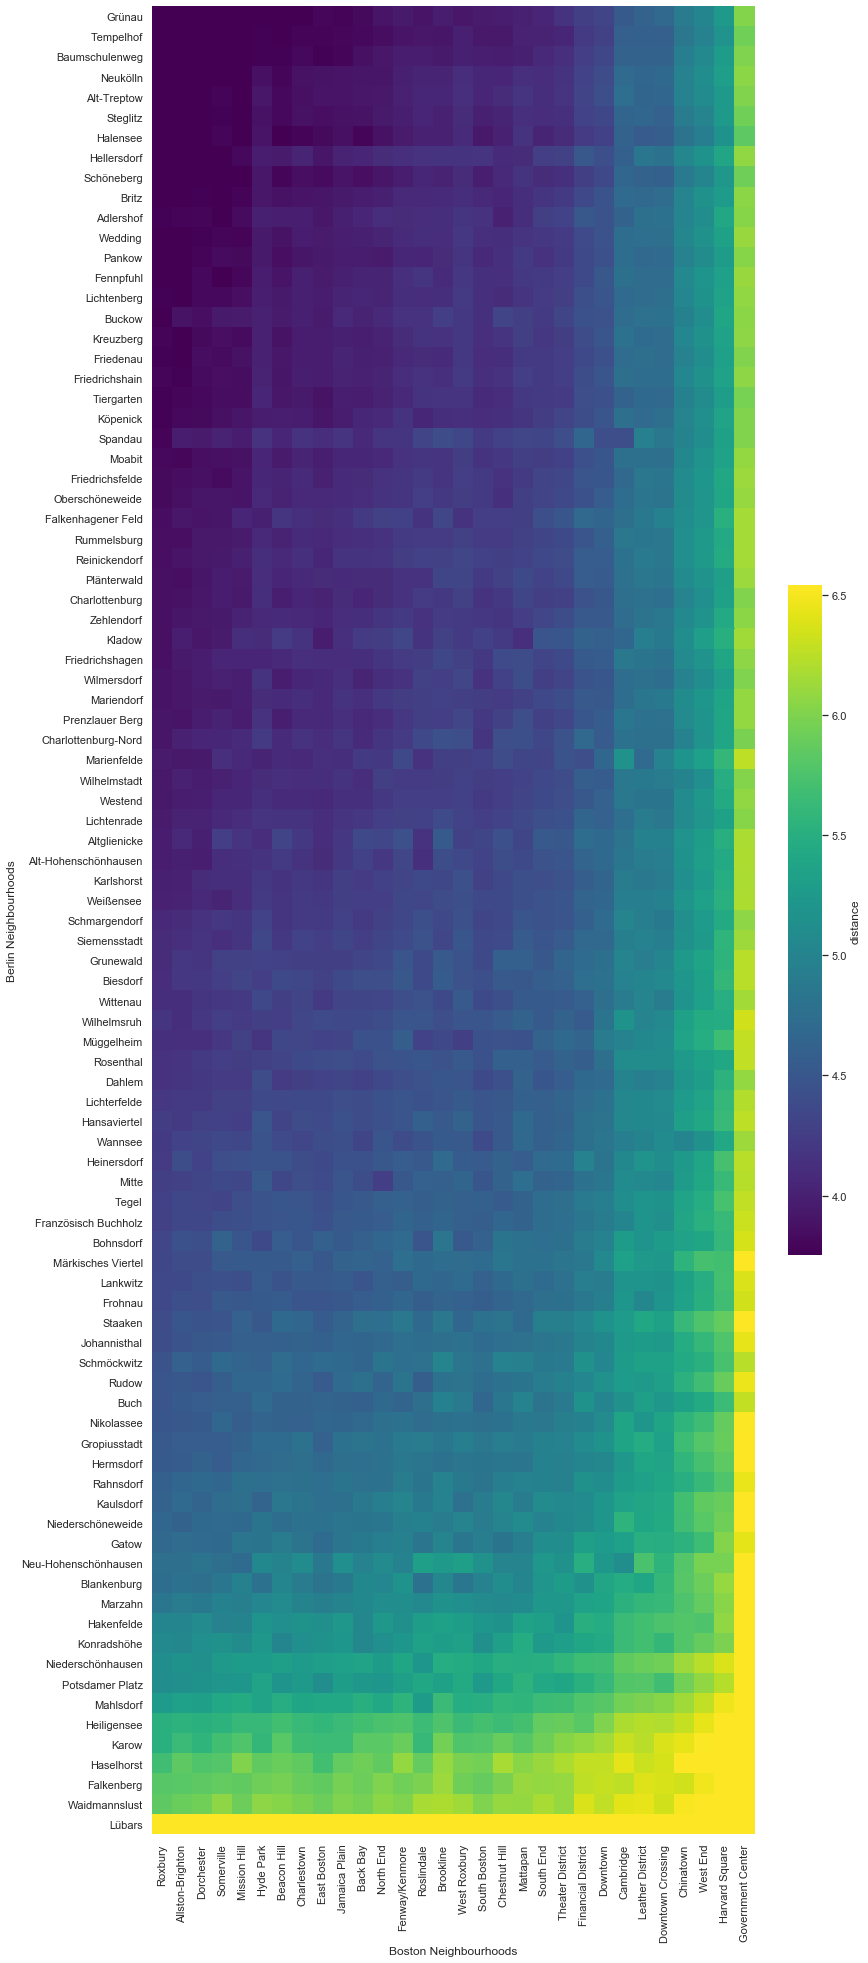

In [149]:
fix, ax = plt.subplots(figsize=(12,36))
sns.heatmap(disfr, annot=False, ax=ax, cmap='viridis', square=True, robust=True, cbar_kws={'fraction': 0.05,
                                                                                           'label': 'distance'})
ax.set_xlabel('Boston Neighbourhoods')
ax.set_ylabel('Berlin Neighbourhoods')
plt.savefig('output/similarity_heatmap.png', bbox_inches='tight')

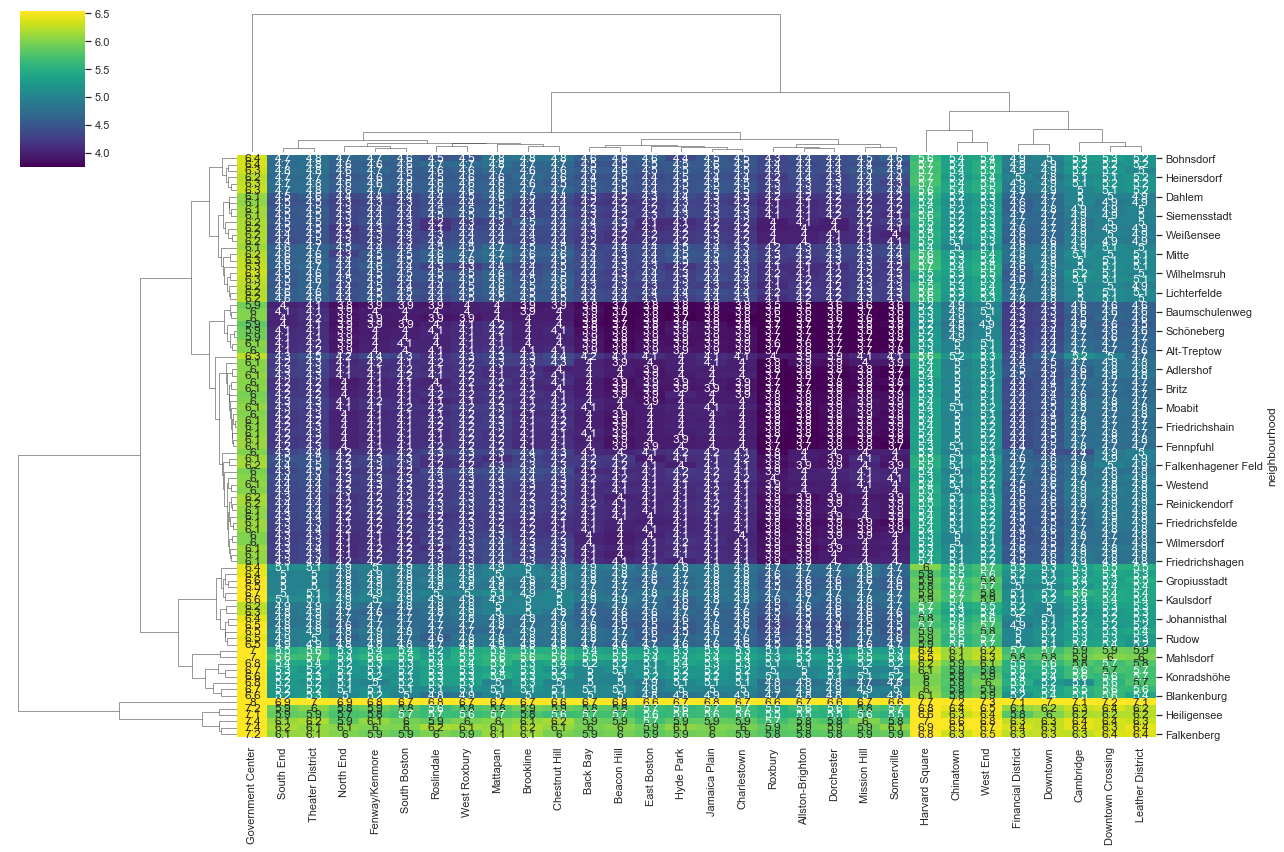

In [121]:
cgrid = sns.clustermap(disfr, annot=False, cmap='viridis', robust=True, figsize=(18,12), cbar_kws={'fraction': 0.05,
                                                                                           'label': 'distance'})
plt.savefig('output/similarity_clustermap.png', bbox_inches='tight')

In [122]:
closest = pd.DataFrame(disfr.min(axis=0), columns=['distance'])
closest['neighbourhood'] = disfr.idxmin(axis=0)
closest['sigma'] = disfr.std(axis=0)
closest.head(30)

,distance,neighbourhood,sigma
Allston-Brighton,3.539580,Tempelhof,0.601213
Jamaica Plain,3.780230,Grünau,0.562998
South End,4.024543,Tempelhof,0.553950
Back Bay,3.787367,Halensee,0.564857
Fenway/Kenmore,3.901969,Tempelhof,0.554167
South Boston,3.927376,Halensee,0.535395
Dorchester,3.568362,Grünau,0.584180
Beacon Hill,3.720945,Tempelhof,0.595357
North End,3.842549,Tempelhof,0.566200
East Boston,3.765719,Baumschulenweg,0.549517


In [123]:
closest['neighbourhood'].value_counts()

Tempelhof         10
Halensee           9
Grünau             7
Baumschulenweg     3
Spandau            1
Name: neighbourhood, dtype: int64

## Comparing Neighborhoods Normalized to City

In [124]:
nbh_mean_relative = nbh_mean.loc[ber_nbh_nam].apply(lambda col: (col - col.min()) / (col.max() - col.min()))
nbh_mean_relative = pd.concat((nbh_mean_relative,
                               nbh_mean.loc[bos_nbh_nam].apply(lambda col: (col - col.min()) / (col.max() - col.min()))))

nbh_mean_relative.sample(20)

,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,is_location_exact,accommodates,bathrooms,bedrooms,beds,square_feet,...,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,bed_type_nan,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,cancellation_policy_nan
neighbourhood,,,,,,,,,,,,,,,,,,,,,
Beacon Hill,0.859653,0.624330,0.031301,0.031301,0.318966,0.116055,0.072797,0.004335,0.071561,0.329412,...,0.000000,0.143678,0.885057,NaN,0.275862,0.666667,NaN,0.065134,NaN,NaN
Wilmersdorf,0.722209,NaN,0.008907,0.008907,0.658385,0.239948,0.159716,0.411255,0.282988,0.175442,...,0.049689,0.149068,0.900621,NaN,0.285714,NaN,0.349896,0.000000,0.0,NaN
Schmargendorf,0.769231,NaN,0.003757,0.003757,0.650000,0.284211,0.057143,0.393939,0.440000,0.142920,...,0.000000,0.400000,0.700000,NaN,0.333333,NaN,0.133333,0.000000,0.0,NaN
Frohnau,1.000000,NaN,0.000894,0.000894,0.875000,0.315789,0.642857,0.636364,0.566667,0.166814,...,0.000000,0.000000,1.000000,NaN,0.333333,NaN,0.166667,0.000000,0.0,NaN
Niederschöneweide,0.800000,NaN,0.001789,0.001789,0.750000,0.070175,0.333333,0.393939,0.133333,NaN,...,0.000000,0.000000,1.000000,NaN,0.166667,NaN,0.222222,0.000000,0.0,NaN
Harvard Square,0.000000,0.952569,0.920904,0.920904,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,...,0.000000,0.000000,1.000000,NaN,0.000000,1.000000,NaN,0.000000,NaN,NaN
Kaulsdorf,0.835000,NaN,0.000947,0.000947,0.735294,0.650155,0.352941,1.000000,0.964706,1.000000,...,0.000000,0.000000,1.000000,NaN,0.411765,NaN,0.352941,0.000000,0.0,NaN
Haselhorst,1.000000,NaN,0.003578,0.003578,0.000000,0.631579,0.000000,0.757576,0.800000,NaN,...,0.000000,0.000000,1.000000,NaN,0.000000,NaN,1.000000,0.000000,0.0,NaN
Lichterfelde,0.846000,NaN,0.004725,0.004725,0.722826,0.247140,0.260870,0.525692,0.404348,0.352655,...,0.000000,0.065217,0.967391,NaN,0.326087,NaN,0.228261,0.000000,0.0,NaN


In [141]:
dis_rel = pd.DataFrame(index=nbh_mean_relative.loc[ber_nbh_nam].index)
for cindex, cvals in nbh_mean_relative.loc[bos_nbh_nam].iterrows():
    dis_rel[cindex] = nbh_mean_relative.loc[ber_nbh_nam].apply(
        lambda x: np.sqrt(np.sum(np.power(x - cvals.values, 2))), axis='columns')
dis_rel['rowmin'] = dis_rel.min(axis=1)
dis_rel.loc['colmin'] = dis_rel.min(axis=0)
dis_rel.sort_values(by='rowmin', axis=0, inplace=True)
dis_rel.sort_values(by='colmin', axis=1, inplace=True)
dis_rel.drop('rowmin', axis=1, inplace=True)
dis_rel.drop('colmin', axis=0, inplace=True)
dis_rel.head(125)

,Beacon Hill,South Boston,South End,Allston-Brighton,Brookline,Mission Hill,Back Bay,Fenway/Kenmore,Charlestown,Theater District,...,Jamaica Plain,Financial District,Chestnut Hill,Mattapan,Leather District,Harvard Square,Cambridge,Chinatown,Government Center,West End
neighbourhood,,,,,,,,,,,,,,,,,,,,,
Prenzlauer Berg,1.519248,1.696463,1.715627,1.936558,2.156936,2.061146,2.052931,2.083936,2.074734,2.137515,...,2.604250,2.533446,2.754254,3.069021,2.783240,3.192239,3.222668,3.386090,3.526628,3.524449
Schöneberg,1.561198,1.664407,1.730717,1.907310,2.051267,2.015680,2.042184,2.038845,2.061124,2.115861,...,2.548263,2.438584,2.710832,2.957900,2.801450,3.159858,3.199498,3.368760,3.463271,3.499400
Charlottenburg,1.582531,1.616284,1.697665,1.862412,1.983912,1.987866,2.037957,2.000705,2.056089,2.026203,...,2.582339,2.448275,2.626003,2.918729,2.783022,3.109598,3.079362,3.278642,3.345849,3.401587
Buckow,1.597956,1.765892,1.718200,2.097686,2.258656,2.199702,2.113103,2.251144,2.059814,2.323102,...,2.639342,2.576851,3.036458,2.943685,2.899913,3.403137,3.123410,3.375993,3.621186,3.493641
Kreuzberg,1.610851,1.855493,1.819376,1.875406,2.167253,1.995817,2.179915,2.175405,2.137343,2.232522,...,2.592263,2.571655,2.757206,3.000194,2.860775,3.373937,3.338268,3.538338,3.681148,3.650572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Waidmannslust,3.412655,2.923299,3.276379,3.032544,3.515011,3.149595,3.114701,3.262100,3.424170,3.003355,...,3.361574,3.868240,3.760855,3.579278,3.755622,3.900060,3.899046,4.096958,4.117776,4.318242
Lübars,3.576089,3.127625,3.511895,3.326907,2.871336,3.423734,3.612561,3.418112,3.553641,3.642406,...,3.669279,3.907556,2.906013,3.291178,3.653648,4.541258,3.865391,4.136187,4.335083,4.335610
Neu-Hohenschönhausen,3.449530,3.502694,3.447335,2.960963,3.530842,2.943341,3.670813,3.338066,3.809338,3.403772,...,3.927238,3.991285,3.491922,3.462166,4.299539,4.033327,3.349696,4.568244,4.710408,4.736495


In [142]:
closest_rel = pd.DataFrame(dis_rel.min(axis=0), columns=['distance'])
closest_rel['neighbourhood'] = dis_rel.idxmin(axis=0)
closest_rel['sigma'] = dis_rel.std(axis=0)
closest_rel.head(30)

,distance,neighbourhood,sigma
Beacon Hill,1.519248,Prenzlauer Berg,0.480016
South Boston,1.616284,Charlottenburg,0.372860
South End,1.697665,Charlottenburg,0.421029
Allston-Brighton,1.702790,Rummelsburg,0.407363
Brookline,1.826311,Siemensstadt,0.429144
Mission Hill,1.866061,Hellersdorf,0.400314
Back Bay,1.993012,Wilmersdorf,0.352709
Fenway/Kenmore,2.000705,Charlottenburg,0.363437
Charlestown,2.015846,Westend,0.370482
Theater District,2.026203,Charlottenburg,0.356715


In [143]:
closest_rel['neighbourhood'].value_counts()


Charlottenburg       4
Kladow               2
Westend              2
Wannsee              2
Tegel                2
Adlershof            1
Niederschönhausen    1
Hellersdorf          1
Prenzlauer Berg      1
Marienfelde          1
Baumschulenweg       1
Rummelsburg          1
Steglitz             1
Buckow               1
Spandau              1
Mitte                1
Lichtenrade          1
Dahlem               1
Siemensstadt         1
Wilmersdorf          1
Reinickendorf        1
Potsdamer Platz      1
Staaken              1
Name: neighbourhood, dtype: int64

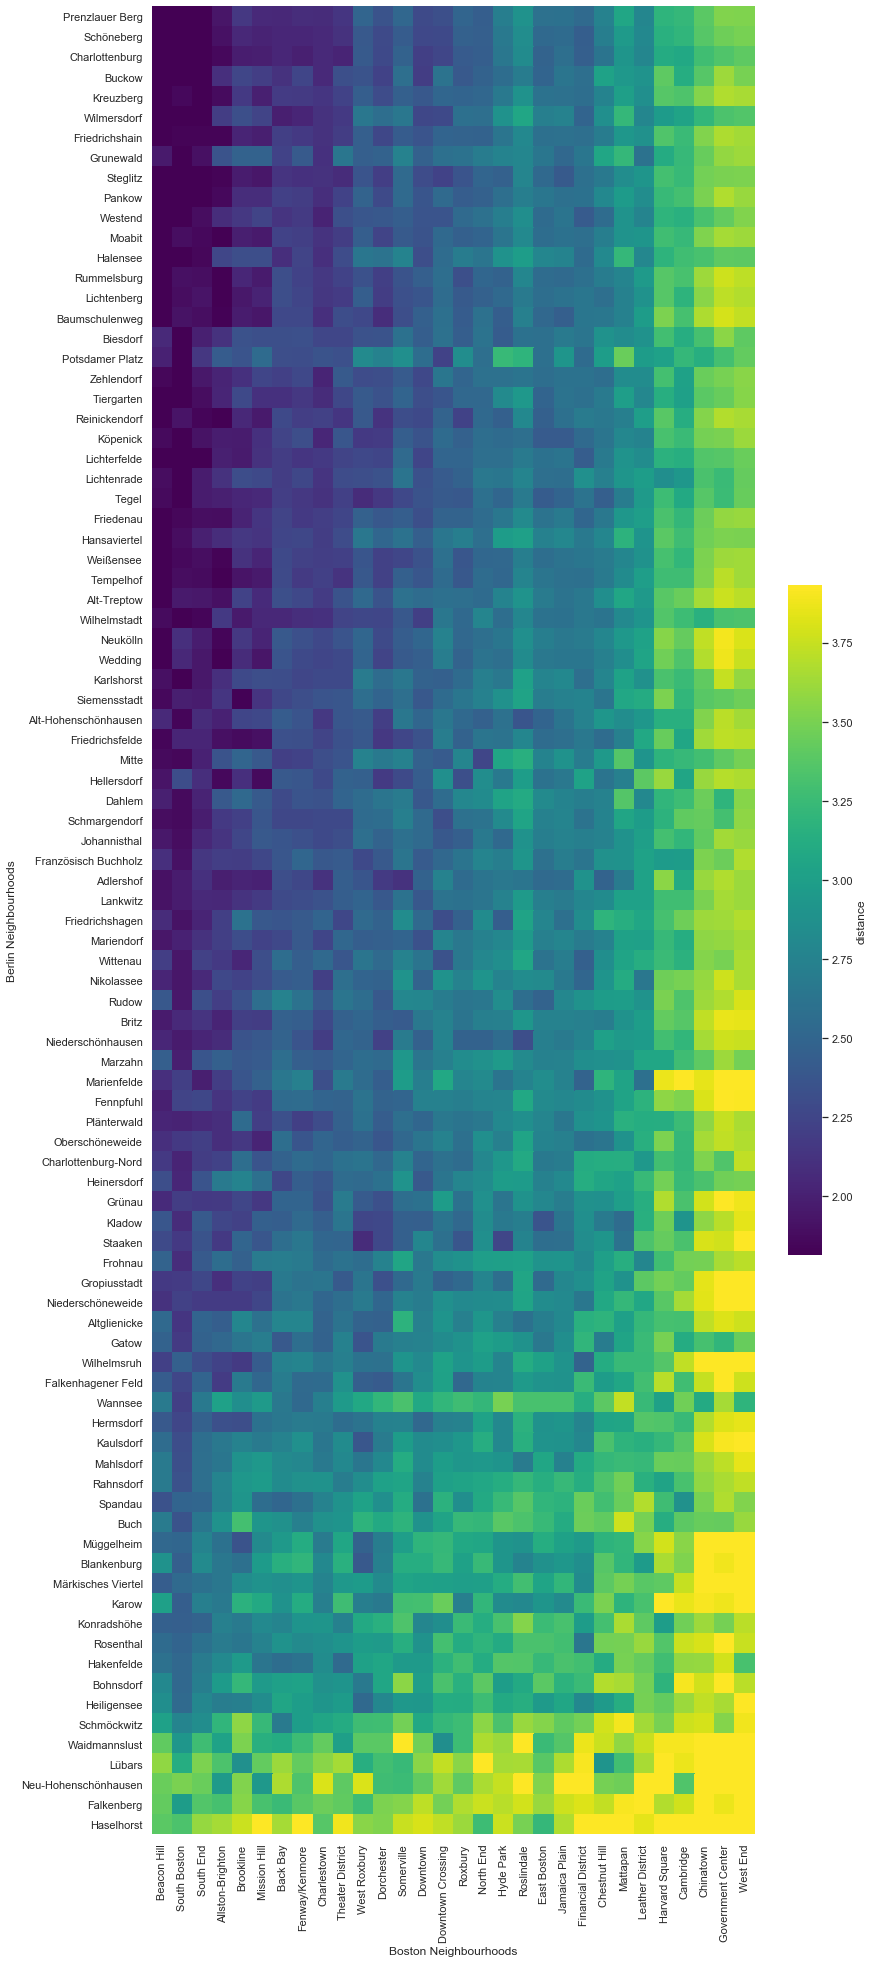

In [150]:
fix, ax = plt.subplots(figsize=(12,36))
sns.heatmap(dis_rel, annot=False, ax=ax, cmap='viridis', square=True, robust=True, cbar_kws={'fraction': 0.05,
                                                                                           'label': 'distance'})
ax.set_xlabel('Boston Neighbourhoods')
ax.set_ylabel('Berlin Neighbourhoods')
plt.suptitle('S')
plt.savefig('output/relative_heatmap.png', bbox_inches='tight')


In [156]:
ber_closest_rel = pd.DataFrame(dis_rel.min(axis=1), columns=['distance'])
ber_closest_rel['neighbourhood'] = dis_rel.idxmin(axis=1)
ber_closest_rel['sigma'] = dis_rel.std(axis=1)

In [161]:
ber_closest_rel.loc[closest_rel['neighbourhood'].value_counts().index].head(35)

,distance,neighbourhood,sigma
Charlottenburg,1.582531,Beacon Hill,0.505302
Kladow,2.074906,South Boston,0.448899
Westend,1.661101,South Boston,0.474432
Wannsee,2.203323,South Boston,0.337387
Tegel,1.754543,South Boston,0.460358
Adlershof,1.908770,Beacon Hill,0.518222
Niederschönhausen,1.968788,South Boston,0.491568
Hellersdorf,1.860087,Allston-Brighton,0.537364
Prenzlauer Berg,1.519248,Beacon Hill,0.532097
Marienfelde,1.993644,South End,0.583922


In [163]:
closest_rel.sort_values(by=['neighbourhood']).head(35)

,distance,neighbourhood,sigma
Somerville,2.117025,Adlershof,0.361708
Dorchester,2.085518,Baumschulenweg,0.338584
Downtown,2.186124,Buckow,0.341984
South Boston,1.616284,Charlottenburg,0.372860
South End,1.697665,Charlottenburg,0.421029
Fenway/Kenmore,2.000705,Charlottenburg,0.363437
Theater District,2.026203,Charlottenburg,0.356715
Government Center,3.189427,Dahlem,0.271961
Mission Hill,1.866061,Hellersdorf,0.400314
Mattapan,2.553599,Kladow,0.301913
